In [12]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

start_time = time.time()
# 데이터 로드, 여기서는 'df'라는 이름의 데이터프레임을 가정합니다.
df = pd.read_csv('load6_2020.csv')


print(df)
# '날짜'를 datetime으로 변환하고 인덱스로 설정
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H')
df = df.set_index('date')

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['load'].values.reshape(-1,1))

# 시퀀스 데이터 생성 함수
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 시퀀스 길이 설정 (가령, 과거 24시간 데이터를 기반으로 미래를 예측)
look_back = 24

# 훈련용 / 테스트용 데이터 분리
train_size = int(len(scaled_data) * 0.75)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# 데이터셋 생성
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# LSTM 입력을 위한 데이터 shape 변환
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(200, input_shape=(1, look_back)))
model.add(Dense(1))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 훈련 (GPU 사용)
with tf.device("/device:GPU:0"):
    model.fit(trainX, trainY, epochs=50, batch_size=12, verbose=1)


# 테스트 데이터에 대한 예측값 생성
testPredict = model.predict(testX)

# 예측값 스케일 역변환
testPredict = scaler.inverse_transform(testPredict)


      Unnamed: 0              date   load
0              0   2020-06-01 0:00  26.81
1              1   2020-06-01 1:00  26.32
2              2   2020-06-01 2:00  26.16
3              3   2020-06-01 3:00  25.94
4              4   2020-06-01 4:00  25.87
...          ...               ...    ...
5131        5131  2020-12-31 19:00  29.58
5132        5132  2020-12-31 20:00  28.23
5133        5133  2020-12-31 21:00  26.81
5134        5134  2020-12-31 22:00  25.45
5135        5135  2020-12-31 23:00  25.16

[5136 rows x 3 columns]
Epoch 1/50
319/319 [==============================] - 2s 3ms/step - loss: 0.0067
Epoch 2/50
319/319 [==============================] - 1s 4ms/step - loss: 4.1566e-04
Epoch 3/50
319/319 [==============================] - 1s 4ms/step - loss: 3.2628e-04
Epoch 4/50
319/319 [==============================] - 1s 4ms/step - loss: 2.5291e-04
Epoch 5/50
319/319 [==============================] - 2s 5ms/step - loss: 2.3085e-04
Epoch 6/50
319/319 [==============================

In [16]:
import matplotlib.pyplot as plt
import datetime

# 실제 데이터 로드
df_actual = pd.read_csv('load1_2021.csv')

# '날짜'를 datetime으로 변환하고 인덱스로 설정
df_actual['date'] = pd.to_datetime(df_actual['date'], format='%Y-%m-%d %H')
df_actual = df_actual.set_index('date')

# 현재 시각

# 예측 하려는 시간 설정

# 예측하려는 날짜 설정
predict_until = pd.to_datetime('2021-01-07 23')

# 예측값을 저장할 빈 리스트 생성
predictions = []

# 현재까지의 전체 데이터 사용
current_data = np.copy(scaled_data)

while len(predictions) < (predict_until - df.index[-1]).total_seconds() / 3600:
    # 가장 최근 데이터를 바탕으로 예측 수행
    sample = current_data[-look_back:]
    sample = np.reshape(sample, (1, 1, look_back))

    # 모델을 사용하여 예측 수행
    predicted_power_usage = model.predict(sample)

    # 예측값을 predictions 리스트에 추가
    predictions.append(predicted_power_usage[0][0])

    # 현재 데이터에 예측값 추가
    current_data = np.append(current_data, predicted_power_usage)

# 예측값 스케일 역변환
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 예측 시간 생성
prediction_dates = pd.date_range(df.index[-1] + pd.Timedelta(hours=1), predict_until, freq='H')

# 실제 데이터와 예측 데이터 플로팅
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['load'], label='Past power usage')
plt.plot(prediction_dates, predictions, label='Predicted power usage')
plt.plot(df_actual.index, df_actual['load'], label='Actual power usage')
#plt.xlim(datetime.date(2020,12,1), datetime.date(2021,1,7))
plt.legend()
plt.title('Power usage prediction')
print(f'Training Time : {time.time() - start_time}')
#plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'testset_2021.csv'

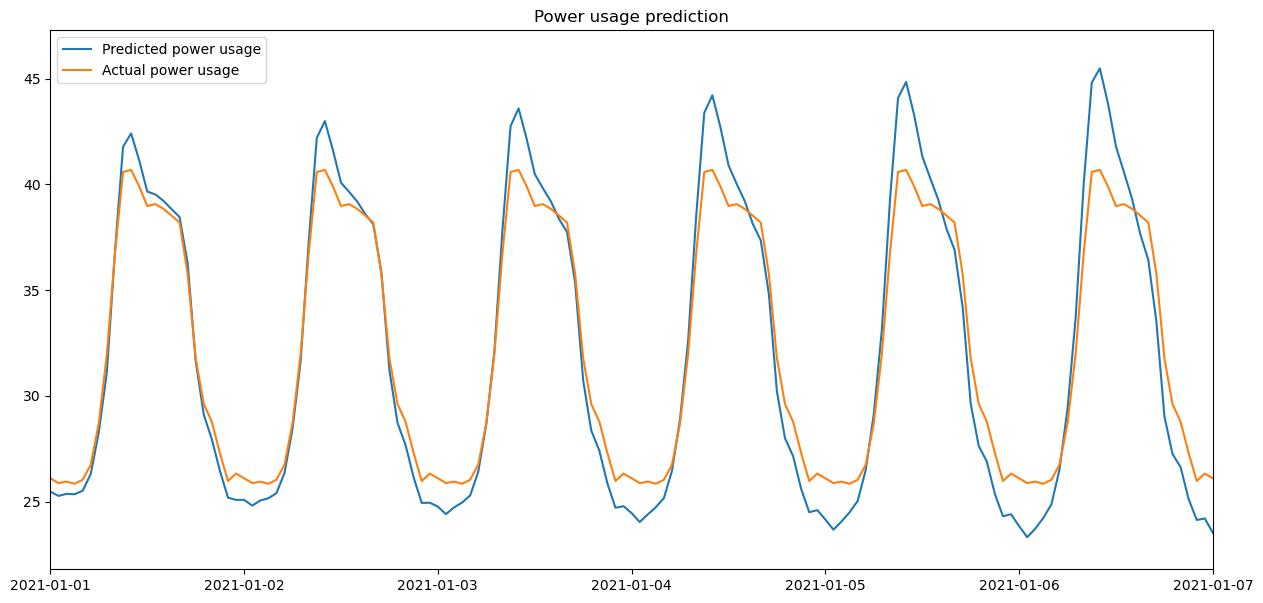

2021-01-01 00:00:00
Actual power usage at 2021-01-01 00:00:00: 26.1
Predicted power usage at 2021-01-01 00:00:00: 25.469999313354492
Error rate at 2021-01-01 00:00:00: 2.43%
2021-01-02 00:00:00
Actual power usage at 2021-01-02 00:00:00: 26.1
Predicted power usage at 2021-01-02 00:00:00: 25.079999923706055
Error rate at 2021-01-02 00:00:00: 3.91%
2021-01-03 00:00:00
Actual power usage at 2021-01-03 00:00:00: 26.1
Predicted power usage at 2021-01-03 00:00:00: 24.760000228881836
Error rate at 2021-01-03 00:00:00: 5.14%
2021-01-04 00:00:00
Actual power usage at 2021-01-04 00:00:00: 26.1
Predicted power usage at 2021-01-04 00:00:00: 24.450000762939453
Error rate at 2021-01-04 00:00:00: 6.31%
2021-01-05 00:00:00
Actual power usage at 2021-01-05 00:00:00: 26.1
Predicted power usage at 2021-01-05 00:00:00: 24.149999618530273
Error rate at 2021-01-05 00:00:00: 7.48%
2021-01-06 00:00:00
Actual power usage at 2021-01-06 00:00:00: 26.1
Predicted power usage at 2021-01-06 00:00:00: 23.8400001525878

In [14]:
# 실제 데이터와 예측 데이터 플로팅
plt.figure(figsize=(15, 7))
#plt.plot(df.index, df['load'], label='Past power usage')
plt.plot(prediction_dates, predictions, label='Predicted power usage')
plt.plot(df_actual.index, df_actual['load'], label='Actual power usage')
plt.xlim(datetime.date(2021,1,1), datetime.date(2021,1,7))

plt.legend()
plt.title('Power usage prediction')
plt.show()


error = []
# 날짜 설정
for i in range(24):
    for j in range(1,8):
        date_to_show = pd.to_datetime('2021-01-'+str(j).zfill(2)+' '+ str(i).zfill(2))
        print(date_to_show)

        # 해당 날짜의 실제 전력 사용량 출력
        actual_power_usage = df_actual.loc[date_to_show, 'load']

        print(f'Actual power usage at {date_to_show}: {actual_power_usage}')

        # 해당 날짜의 예측된 전력 사용량 출력
        predicted_power_usage = predictions[prediction_dates.get_loc(date_to_show)]
        print(f'Predicted power usage at {date_to_show}: {round(predicted_power_usage[0],2)}')

        # 오차율 계산
        error_rate = (abs(actual_power_usage - predicted_power_usage[0]) / actual_power_usage) * 100
        error.append(error_rate)

        # 오차율 출력
        print(f'Error rate at {date_to_show}: {error_rate:.2f}%')

print(f'average error rate : {np.mean(error):.2f}%')